In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

import time
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report


In [2]:
def features(image, extractor):
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors


def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv.xfeatures2d.SIFT_create()
    for key,value in images.items():
        feature_lst = []
        for img in value:
            kp, des = features(img, sift)
            descriptor_list.extend(des)
            feature_lst.append(des)
        sift_vectors[key] = feature_lst
    return [descriptor_list, sift_vectors]


def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_
    return visual_words


def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if i == 0:
           count = distance.euclidean(image, center[i])
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i])
            #dist = L1_dist(image, center[i])
            if dist < count:
                ind = i
                count = dist
    return ind


def image_class_training(all_bovw, centers):
    dict_feature = {}
    for class_name, img_feat in all_bovw.items():
        category = []
        for dscr in img_feat:
            histogram = np.zeros(len(centers))
            for each_feature in dscr:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[class_name] = category
    return dict_feature


def get_histogram(descs: pd.Series, centers):
    histogram = np.zeros(len(centers))
    for each_feature in descs:
        ind = find_index(each_feature, centers)
        histogram[ind] += 1
    return histogram


def knn(train_bow, test):
    first = True
    for train_key, train_feat in train_bow.items():
        for train in train_feat:
            if first:
                minimum = distance.euclidean(test, train)
                #minimum = L1_dist(tst,train)
                y_pred = train_key
                first = False
            else:
                dist = distance.euclidean(test, train)
                #dist = L1_dist(tst,train)
                if dist < minimum:
                    minimum = dist
                    y_pred = train_key
    return y_pred


def resize_img(img_src):
    img = cv.resize(img_src, (500, 500), interpolation=cv.INTER_CUBIC)
    return img

In [3]:
# PREPROCESSING
df_training = pd.read_csv('data/train.csv', names=['name', 'label', 'lbl_no'])
df_test = pd.read_csv('data/test.csv', names=['name', 'label', 'lbl_no'])
training_imgs_names = os.listdir('data/Training')
training_imgs = [cv.imread(f'data/Training/{name}') for name in training_imgs_names]
test_imgs_names = os.listdir('data/TestSingleObjects')
test_imgs = [cv.imread(f'data/TestSingleObjects/{name}') for name in test_imgs_names]
dc_training = dict(names=training_imgs_names, imgs=training_imgs)
print(df_training.shape)
assert len(training_imgs_names) == df_training.shape[0]
df_training['img_raw']=training_imgs
df_test['img_raw']=test_imgs
# df_training = pd.DataFrame(dc_training)
df_test[['name','label']]

(75, 3)


,name,label
0,84.JPG,Airblower
1,85.JPG,Airblower
2,72.JPG,Bells
3,73.JPG,Bells
4,13.JPG,Brush
...,...,...
68,5.JPG,USAF
69,7.JPG,USAF
70,205.JPG,Vegetation3
71,174.JPG,Vegetation4


In [4]:
# SIFT
df_training['imgs_gray_raw'] = df_training['img_raw'].apply(lambda x: cv.cvtColor(x, cv.COLOR_RGB2GRAY))
df_test['imgs_gray_raw'] = df_test['img_raw'].apply(lambda x: cv.cvtColor(x, cv.COLOR_RGB2GRAY))

df_training['imgs_gray'] = df_training['imgs_gray_raw'].apply(resize_img)
df_test['imgs_gray'] = df_test['imgs_gray_raw'].apply(resize_img)
sift = cv.xfeatures2d.SIFT_create()
with tf.device('/device:GPU:0'):
    training_features = df_training['imgs_gray'].apply(lambda x: features(x, sift))
    test_features = df_test['imgs_gray'].apply(lambda x: features(x, sift))
    df_training['sift_keypoints'] = training_features.apply(lambda x: x[0])
    df_training['sift_descriptors'] = training_features.apply(lambda x: x[1])
    df_test['sift_keypoints'] = test_features.apply(lambda x: x[0])
    df_test['sift_descriptors'] = test_features.apply(lambda x: x[1])
df_training.to_csv('training_sift.csv', index=False)
df_test.to_csv('test_sift.csv', index=False)

In [8]:
# BAG OF WORDS

labels = set(df_training.lbl_no.values)
images = dict()
test_images = dict()
for lbl in labels:
    images[lbl] = df_training.loc[df_training.lbl_no == lbl, 'imgs_gray'].values
    if lbl in df_test['lbl_no'].values:
        test_images[lbl] = df_test.loc[df_test.lbl_no == lbl, 'imgs_gray'].values

In [9]:
with tf.device('/device:GPU:0'):
    sifts = sift_features(images)
    # Takes the descriptor list which is unordered one
    descriptor_list = sifts[0]
    all_bovw_feature = sifts[1]
    bag_of_visual_words = kmeans(100, descriptor_list)

    # Creates histograms for train data
    bovw_train = image_class_training(all_bovw_feature, bag_of_visual_words)
    # Creates histograms for test data
    df_test['histograms'] = df_test['sift_descriptors'].apply(lambda x: get_histogram(x, bag_of_visual_words))
    bovw_test = df_test['histograms'].values

In [10]:
pred = df_test['histograms'].apply(lambda x: knn(bovw_train, x))

# Calculates the accuracies and write the results to the console.
print(classification_report(df_test['lbl_no'].values, pred.values))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.50      0.40      0.44         5
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4
          17       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         2
          19       0.00    

C:\Users\HS-Rn7\anaconda3\envs\LabWork\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HS-Rn7\anaconda3\envs\LabWork\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# HOG
SZ=20
bin_n = 16 # Number of bins
affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR
def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
def hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, ang = cv.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist

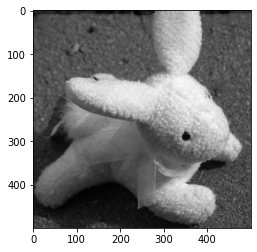

array([[26.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [23.071068,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 8.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [71.42546 ,  0.      , 17.492855, ...,  0.      ,  0.      ,
         0.      ],
       [26.      , 31.874952, 18.602325, ...,  0.      ,  0.      ,
         0.      ],
       [49.30387 , 54.02871 , 47.212322, ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [7]:
img = df_training['imgs_gray'][0]
plt.imshow(img, cmap='gray')
plt.show()
if img is None:
    raise Exception("we need the image from here !")


cells = [np.hsplit(row,100) for row in np.vsplit(img,50)]
# First half is trainData, remaining is testData
train_cells = [ i[:50] for i in cells ]
test_cells = [ i[50:] for i in cells]
deskewed = [list(map(deskew,row)) for row in train_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
trainData = np.float32(hogdata).reshape(-1,64)
responses = np.repeat(np.arange(10),250)[:,np.newaxis]
deskewed = [list(map(deskew,row)) for row in test_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
testData = np.float32(hogdata).reshape(-1,bin_n*4)
with tf.device('/device:GPU:0'):
    start = time.time()
    print("Start SVM computing")
    svm = cv.ml.SVM_create()
    svm.setKernel(cv.ml.SVM_LINEAR)
    svm.setType(cv.ml.SVM_C_SVC)
    svm.setC(2.67)
    svm.setGamma(5.383)
    svm.train(trainData, cv.ml.ROW_SAMPLE, responses)
    print("End time : ", time.time() - start)
    # svm.save('models/svm_data.dat')
    start = time.time()
    print("Start SVM pred")
    result = svm.predict(testData)[1]
    print("End time : ", time.time() - start)
    mask = result==responses
    correct = np.count_nonzero(mask)
    print(correct*100.0/result.size)

### Local binary patterns

In [74]:
# import the necessary packages
from skimage import feature

class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))
        # normalize the histogram
        hist = hist.astype(np.float)
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return list(hist)

In [94]:
from sklearn.svm import LinearSVC
import cv2
import os
# initialize the local binary patterns descriptor along with
# the data and label lists
desc = LocalBinaryPatterns(50, 8)
data = df_training['imgs_gray'].apply(desc.describe)
data = list(data.values)
labels = df_training['lbl_no']
# train a Linear SVM on the data
model = LinearSVC(C=100.0, random_state=42)
model.fit(data, labels.values)

test_data = df_test['imgs_gray'].apply(desc.describe)
test_data = list(test_data.values)
test_labels = df_test['lbl_no']
predictions = model.predict(test_data)
print('Acurr: ', np.count_nonzero(predictions == test_labels) * 100 / len(predictions))

C:\Users\HS-Rn7\anaconda3\envs\LabWork\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Acurr:  2.73972602739726
